In [1]:
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from matplotlib import pyplot

In [2]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            pyplot.subplot2grid((3,3),(i,j))
            pyplot.imshow(X[k])
            k = k+1
    pyplot.show()


# EDA

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

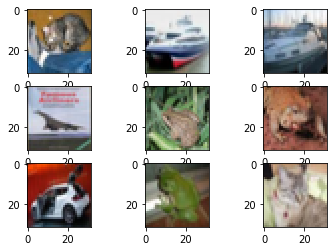

In [4]:
#visualise test data
show_imgs(x_test[:9])

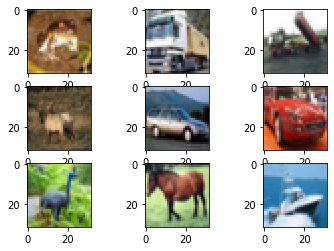

In [5]:
#visualise training data
show_imgs(x_train[:9])

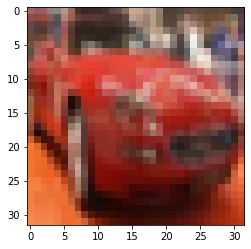

In [6]:
pyplot.imshow(x_train[5])

In [7]:
print('Labels:' , np.unique(y_train))

Labels: [0 1 2 3 4 5 6 7 8 9]


In [8]:
print('X train: ' , x_train.shape)
print('Y train: ' , y_train.shape)
print('X test: ', x_test.shape)
print('Y test: ', y_test.shape)

X train:  (50000, 32, 32, 3)
Y train:  (50000, 1)
X test:  (10000, 32, 32, 3)
Y test:  (10000, 1)


# Preprocessing

In [9]:
#data augmentation and normalization

from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = x_train/255
x_test = x_test/255

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

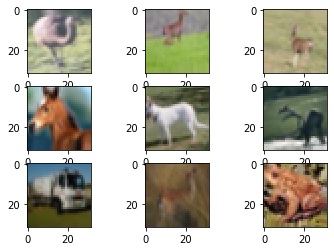

In [10]:
#visualise augmented and normalised training images

from matplotlib import pyplot as plt

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=True):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32, 3))
    plt.show()
    break

In [11]:
#one hot encode target variable

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [12]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# Model

In [13]:
#model

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='elu', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [15]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 45:
        lrate = 0.0005
    if epoch > 80:
        lrate = 0.0001
    if epoch > 115:
        lrate = 0.00002
    return lrate

In [16]:
#training
batch_size = 64

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=120,\
                    verbose=1, validation_data=(x_test,y_test), callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/120
781/781 [==============================] - 20s 25ms/step - loss: 1.6512 - accuracy: 0.4472 - val_loss: 1.3826 - val_accuracy: 0.5518 - lr: 0.0010
Epoch 2/120
781/781 [==============================] - 19s 24ms/step - loss: 1.1641 - accuracy: 0.5927 - val_loss: 1.3649 - val_accuracy: 0.6017 - lr: 0.0010
Epoch 3/120
781/781 [==============================] - 19s 24ms/step - loss: 0.9753 - accuracy: 0.6626 - val_loss: 1.0483 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 4/120
781/781 [==============================] - 19s 24ms/step - loss: 0.8642 - accuracy: 0.7008 - val_loss: 0.8318 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 5/120
781/781 [==============================] - 20s 25ms/step - loss: 0.7795 - accuracy: 0.7281 - val_loss: 0.9291 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 6/120
781/781 [==============================] - 20s 26ms/step - loss: 0.7290 - accuracy: 0.7462 - val_loss: 0.6427 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 7/120
781/781 [==============================]

781/781 [==============================] - 20s 26ms/step - loss: 0.2803 - accuracy: 0.9002 - val_loss: 0.3830 - val_accuracy: 0.8773 - lr: 5.0000e-04
Epoch 53/120
781/781 [==============================] - 20s 26ms/step - loss: 0.2839 - accuracy: 0.8996 - val_loss: 0.3765 - val_accuracy: 0.8797 - lr: 5.0000e-04
Epoch 54/120
781/781 [==============================] - 20s 25ms/step - loss: 0.2786 - accuracy: 0.9016 - val_loss: 0.3843 - val_accuracy: 0.8774 - lr: 5.0000e-04
Epoch 55/120
781/781 [==============================] - 20s 26ms/step - loss: 0.2824 - accuracy: 0.9003 - val_loss: 0.3759 - val_accuracy: 0.8831 - lr: 5.0000e-04
Epoch 56/120
781/781 [==============================] - 20s 26ms/step - loss: 0.2783 - accuracy: 0.9020 - val_loss: 0.3539 - val_accuracy: 0.8888 - lr: 5.0000e-04
Epoch 57/120
781/781 [==============================] - 21s 26ms/step - loss: 0.2758 - accuracy: 0.9021 - val_loss: 0.3987 - val_accuracy: 0.8712 - lr: 5.0000e-04
Epoch 58/120
781/781 [=============

781/781 [==============================] - 19s 24ms/step - loss: 0.2106 - accuracy: 0.9249 - val_loss: 0.3570 - val_accuracy: 0.8927 - lr: 1.0000e-04
Epoch 103/120
781/781 [==============================] - 19s 25ms/step - loss: 0.2067 - accuracy: 0.9266 - val_loss: 0.3565 - val_accuracy: 0.8923 - lr: 1.0000e-04
Epoch 104/120
781/781 [==============================] - 19s 25ms/step - loss: 0.2094 - accuracy: 0.9267 - val_loss: 0.3646 - val_accuracy: 0.8902 - lr: 1.0000e-04
Epoch 105/120
781/781 [==============================] - 19s 25ms/step - loss: 0.2055 - accuracy: 0.9253 - val_loss: 0.3669 - val_accuracy: 0.8920 - lr: 1.0000e-04
Epoch 106/120
781/781 [==============================] - 19s 25ms/step - loss: 0.2095 - accuracy: 0.9259 - val_loss: 0.3725 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 107/120
781/781 [==============================] - 19s 24ms/step - loss: 0.2096 - accuracy: 0.9255 - val_loss: 0.3586 - val_accuracy: 0.8921 - lr: 1.0000e-04
Epoch 108/120
781/781 [=======

In [17]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=256, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

40/40 [==============================] - 0s 10ms/step - loss: 0.3503 - accuracy: 0.8945

Test result: 89.450 loss: 0.350


In [18]:
#save locally
model.save('cifar.h5')    

# Load Saved Model and Predict

In [21]:
# Load trained model
model = keras.models.load_model('cifar.h5')


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    #steps_per_epoch=x_train.shape[0] // batch_size, epochs=20,\
                    #verbose=1, validation_data=(x_test,y_test))

In [22]:
x = np.argmax(model.predict(x_test[0:10000]),1)

In [23]:
np.array(np.unique(x, return_counts=True)).T

array([[   0, 1012],
       [   1, 1028],
       [   2,  942],
       [   3,  847],
       [   4, 1043],
       [   5,  924],
       [   6, 1156],
       [   7, 1001],
       [   8,  981],
       [   9, 1066]], dtype=int64)

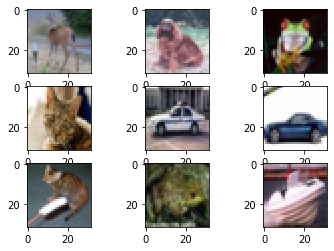

Predicted: ['deer', 'dog', 'frog', 'frog', 'automobile', 'automobile', 'frog', 'frog', 'ship']
True Labels:  ['deer', 'dog', 'frog', 'cat', 'automobile', 'automobile', 'cat', 'frog', 'ship']


In [25]:
#visualise test results

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

show_imgs(x_test[100:109])
 
#true value of labels
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print ('Predicted:', [labels[y] for y in x[100:109]])
val = []
for x in y_test[100:109]:
    val.append(x[0])
print('True Labels: ', [labels[x] for x in val])

In [26]:
np.array(np.unique(y_test, return_counts=True)).T

array([[   0, 1000],
       [   1, 1000],
       [   2, 1000],
       [   3, 1000],
       [   4, 1000],
       [   5, 1000],
       [   6, 1000],
       [   7, 1000],
       [   8, 1000],
       [   9, 1000]], dtype=int64)

# Analyze Permormance

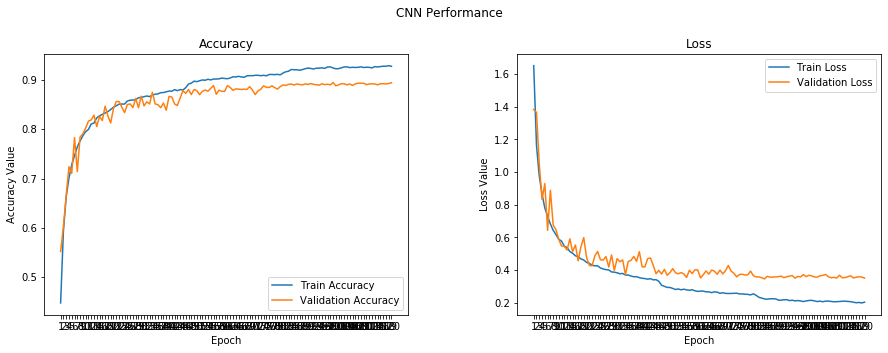

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,120+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")